In [1]:
import pandas as pd

In [2]:
rates = pd.read_excel("usd_rates.xlsx")

In [3]:
rates.head()

nominal       data     curs         cdx
0        1 2017-01-10  59.8961  Доллар США
1        1 2017-01-11  59.9533  Доллар США
2        1 2017-01-12  60.1614  Доллар США
3        1 2017-01-13  59.4978  Доллар США
4        1 2017-01-14  59.3700  Доллар США

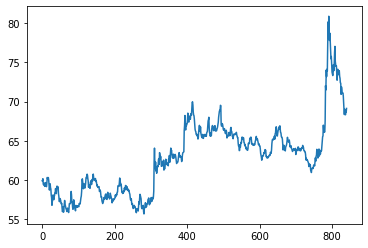

In [4]:
rates.curs.plot()

In [5]:
random_state = 42

past = 28
future = 7

sample_len = past + future

start = past
end = len(rates.curs) - sample_len

dataframe = [list(rates.curs[st:(st+sample_len)]) for st in range(0, end)]
past_columns = [f'past_{i}' for i in range(past)]
future_columns = [f'future_{i}' for i in range(future)]

usd = pd.DataFrame(dataframe, columns=past_columns+future_columns)

In [6]:
usd.describe()

past_0      past_1      past_2      past_3      past_4      past_5  \
count  806.000000  806.000000  806.000000  806.000000  806.000000  806.000000   
mean    62.425377   62.443701   62.463928   62.484872   62.504265   62.523305   
std      4.268634    4.289414    4.316012    4.345678    4.367157    4.386884   
min     55.671700   55.671700   55.671700   55.671700   55.671700   55.671700   
25%     58.562550   58.562550   58.562550   58.562550   58.562550   58.562550   
50%     62.975100   62.986000   63.000500   63.013500   63.028150   63.040550   
75%     65.406050   65.415000   65.419475   65.423325   65.427625   65.431250   
max     80.881500   80.881500   80.881500   80.881500   80.881500   80.881500   

           past_6      past_7      past_8      past_9  ...     past_25  \
count  806.000000  806.000000  806.000000  806.000000  ...  806.000000   
mean    62.541778   62.560599   62.578597   62.595190  ...   62.854358   
std      4.405895    4.424822    4.440541    4.453439  ...    4.646402   
min     55.671700   55.671700   55.671700   55.671700  ...   55.671700   
25%     58.562550   58.562550   58.562550   58.562550  ...   58.562550   
50%     63.046100   63.050550   63.064850   63.079600  ...   63.222550   
75%     65.437500   65.439750   65.462700   65.472025  ...   65.603875   
max     80.881500   80.881500   80.881500   80.881500  ...   80.881500   

          past_26     past_27    future_0    future_1    future_2    future_3  \
count  806.000000  806.000000  806.000000  806.000000  806.000000  806.000000   
mean    62.870102   62.884956   62.900107   62.913991   62.928111   62.941182   
std      4.651640    4.654349    4.654300    4.653819    4.655045    4.656253   
min     55.671700   55.671700   55.671700   55.671700   55.671700   55.671700   
25%     58.573200   58.579300   58.588975   58.631875   58.692800   58.697550   
50%     63.226100   63.226600   63.233150   63.243800   63.254200   63.267500   
75%     65.606175   65.608950   65.616075   65.619250   65.627325   65.633350   
max     80.881500   80.881500   80.881500   80.881500   80.881500   80.881500   

         future_4    future_5    future_6  
count  806.000000  806.000000  806.000000  
mean    62.954151   62.968045   62.981297  
std      4.656638    4.656979    4.657842  
min     55.671700   55.671700   55.671700  
25%     58.710400   58.720400   58.755900  
50%     63.282800   63.299750   63.343800  
75%     65.647400   65.651700   65.658000  
max     80.881500   80.881500   80.881500  

[8 rows x 35 columns]

# Немного облегчим себе жизнь для эесперимента с моделями. 

В Ячейке ниже — код для запуска запуска модели и «проверки» ее качества. Функция строит несколько графиков по некоторым случайно вязтым дням из тестовой выборки. 

In [7]:
from random import sample

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


def get_indexes_for_plots(n_inexes, sample_size):
    return sample(range(sample_size), k=n_inexes)
    

def try_model(model, *, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')

    print(f'mae: {mae}')
    print(f'mae avg: {mean_absolute_error(Y_test, Y_pred, multioutput="uniform_average")}')

    n_Y = len(Y_test)
    plot_indexes = get_indexes_for_plots(min(6, n_Y), n_Y)

    Y_pred_plot = Y_pred[plot_indexes]
    Y_test_plot = Y_test.iloc[plot_indexes]

    n_Y_plot = len(Y_test_plot)
    
    n_plot_columns = 3
    n_plot_rows = n_Y_plot // 3 + (1 if n_Y_plot % 3 else 0)

    fix, axs = plt.subplots(n_plot_rows, n_plot_columns, figsize=(20, 10))
    for i in range(n_Y_plot):
        ax = axs[i // n_plot_columns, i % n_plot_columns]
        ax.plot(Y_pred[i], label='Prediction')
        ax.plot(Y_test.iloc[i], label='Real')
        ax.legend()
    plt.show()

    plt.plot(mae, label='MAE')
    plt.show()


In [8]:
# Stolen as is from the seminars notebook.

X = usd[past_columns] # Входные данные, ТО на основе чего мы пытаемся сделать прогноз
Y = usd[future_columns] # Выходные данные, ТО что мы пытаемся спрогнозировать

# Тренировочная выборка, это та, на которой мы тренируем модель, "УЧЕБНИК"
X_train = X[:-10] # "Задачи Учебника"
Y_train = Y[:-10] # "Ответы на задачи учебника"

# Тестовая (проверочная) выборка, это та на который мы проверим качество обучения модели, "Экзамен"
X_test = X[-10:] # Задачи экзамена
Y_test = Y[-10:] # Ответы на задчи экзамена

mae: [0.5625613  0.85352077 0.82514454 1.08896414 1.35819319 1.50644772
 1.53466008]
mae avg: 1.104213105815156


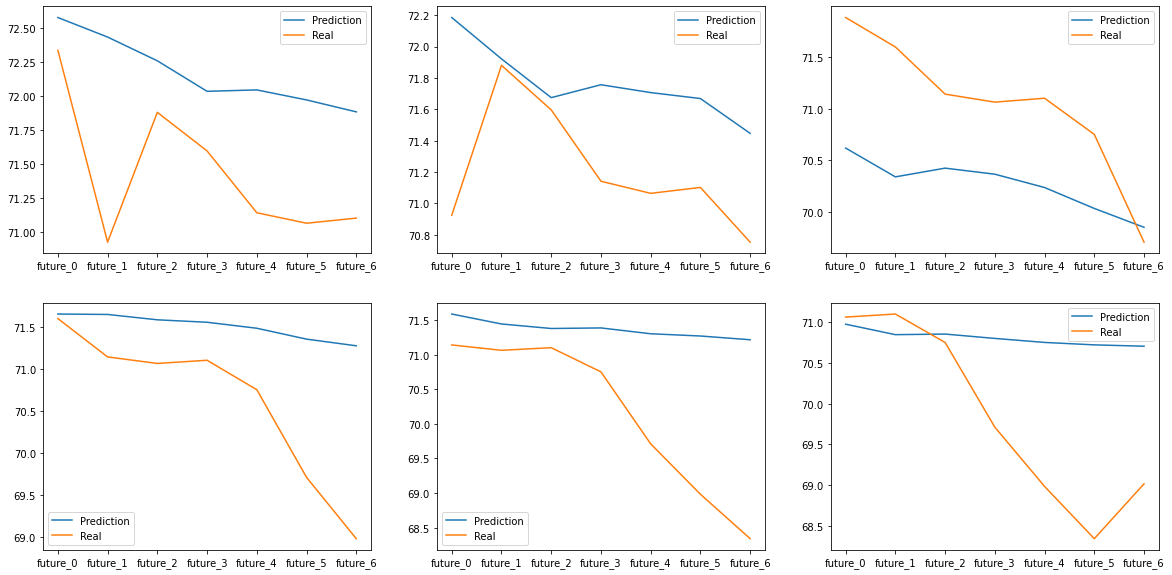

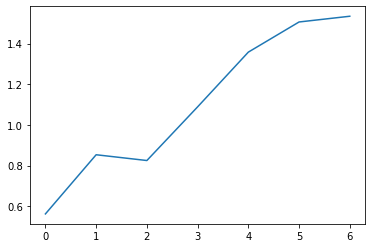

In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression() 
try_model(model, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

mae: [1.90999667 2.02051    1.52613333 1.68051667 1.76160667 2.08050333
 2.05272333]
mae avg: 1.8617128571428558


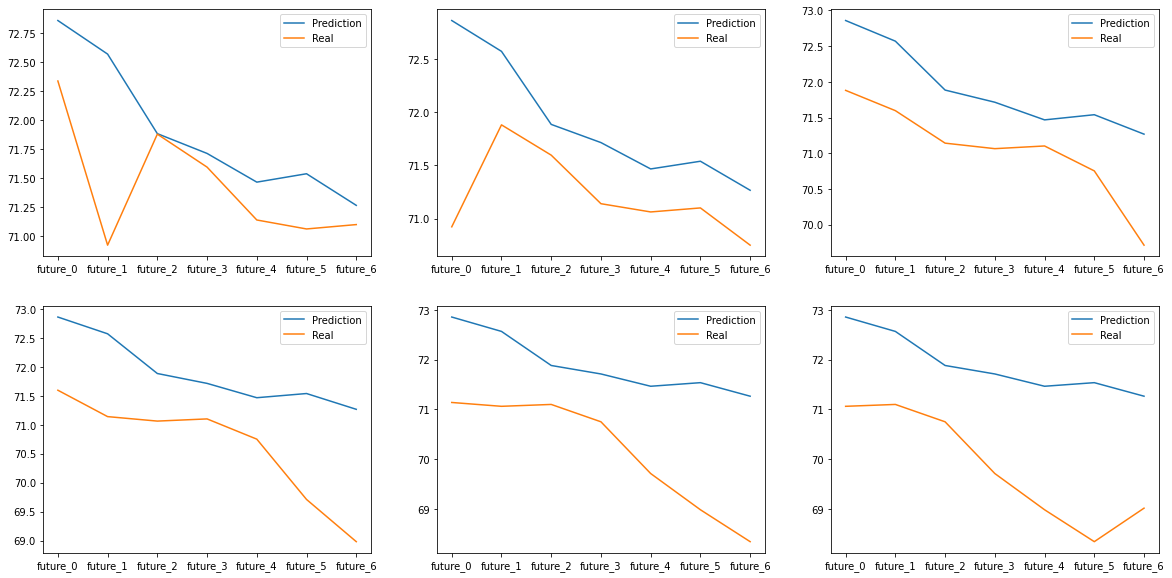

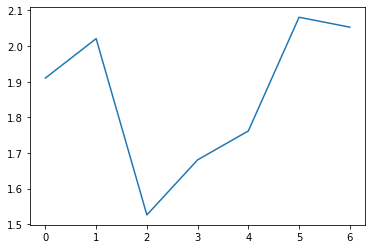

In [10]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=3)
try_model(model, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

mae: [0.6100922  0.84770379 0.94688112 1.31374568 1.63231988 1.86515699
 2.08149513]
mae avg: 1.3281992559192


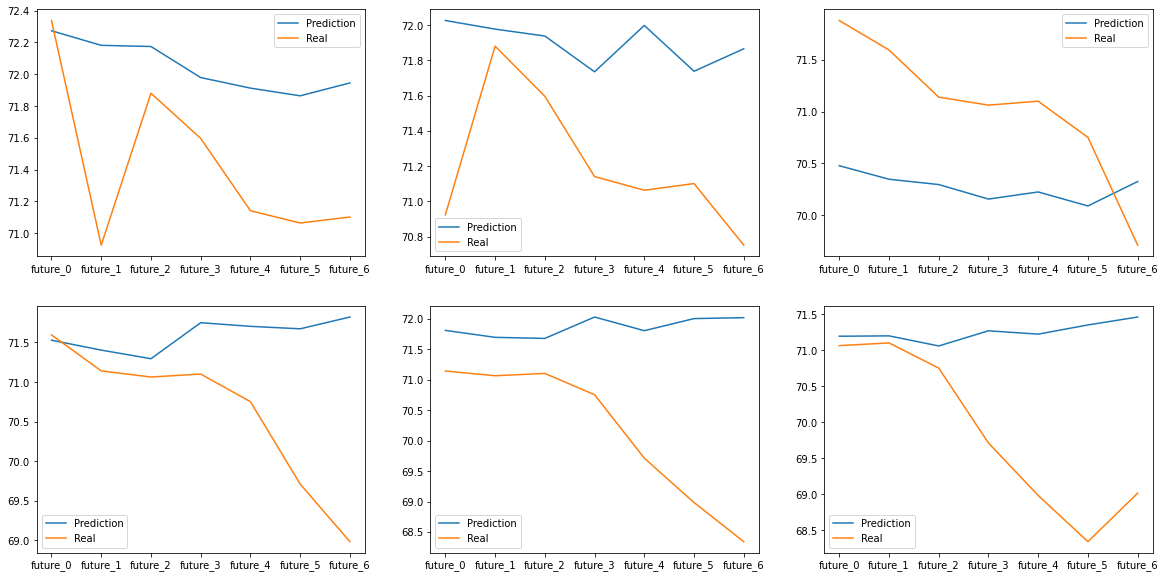

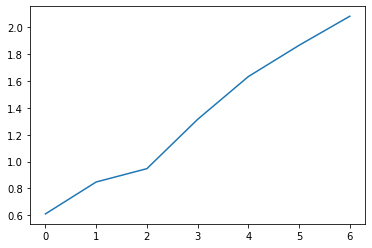

In [11]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(max_iter=1000, solver='lbfgs', hidden_layer_sizes=(100, 100, 100), random_state=random_state)
try_model(model, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

# Считаем MAE для MLPRegressor по первому дню, чтобы «победить» 0.885

## Что сделали

Взяли другой слолвер, который по заверениям документации хорошо работает на небольших выборках и наугад подобрали форму слоев («наугад» совпал с тем, что было на семинаре, такое вполне может случиться с наугадом).

MAE = 0.6308242955141391 — победа!




In [12]:
Y_pred = model.predict(X_test.iloc[[0]])
mean_absolute_error(list(Y_test.iloc[0]), Y_pred[0])

0.6308242955141391

mae: [0.48072071 0.62562739 0.60858058 0.85848463 1.16490262 1.30414087
 1.42131672]
mae avg: 0.9233962155047123


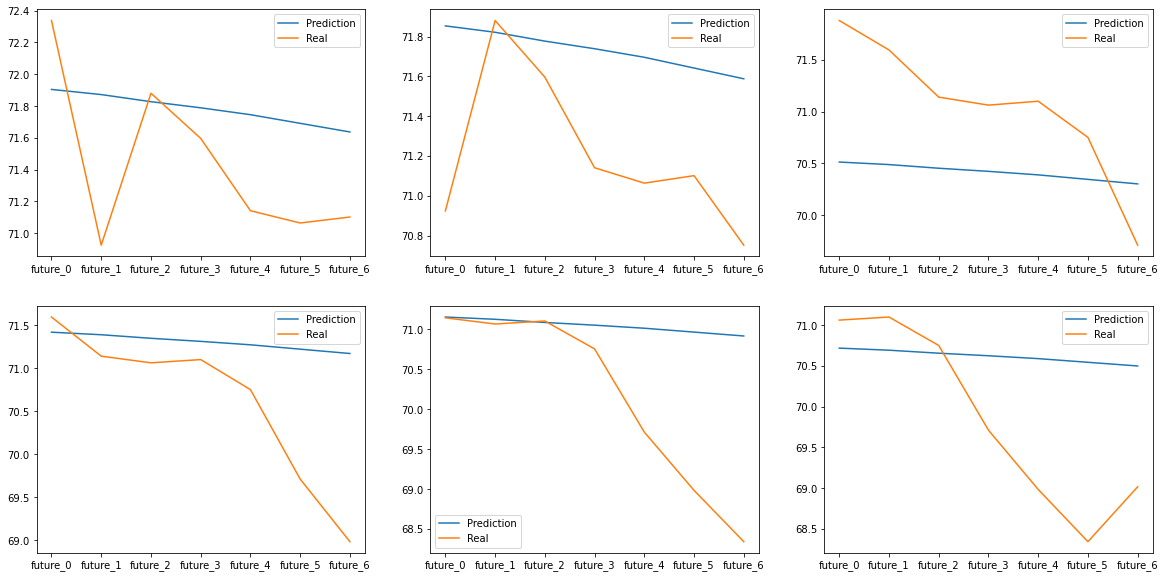

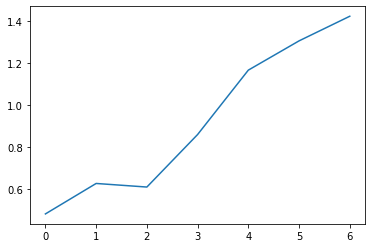

In [13]:
from sklearn.linear_model import Lasso
model = Lasso(random_state=random_state)
try_model(model, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

mae: [0.45781997 0.71306299 0.76937183 1.041446   1.31794404 1.50545419
 1.6949758 ]
mae avg: 1.0714392592090116


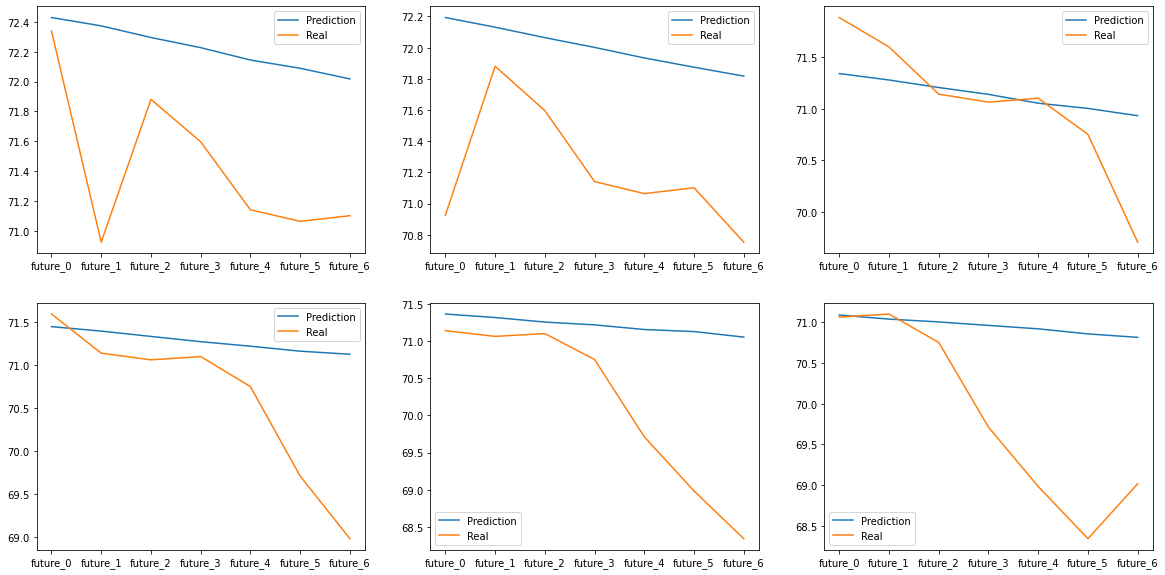

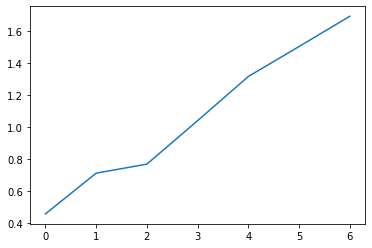

In [14]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(random_state=random_state)
try_model(model, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

mae: [0.56117952 0.85218676 0.82474276 1.08818889 1.35790025 1.50606822
 1.535768  ]
mae avg: 1.1037191997324232


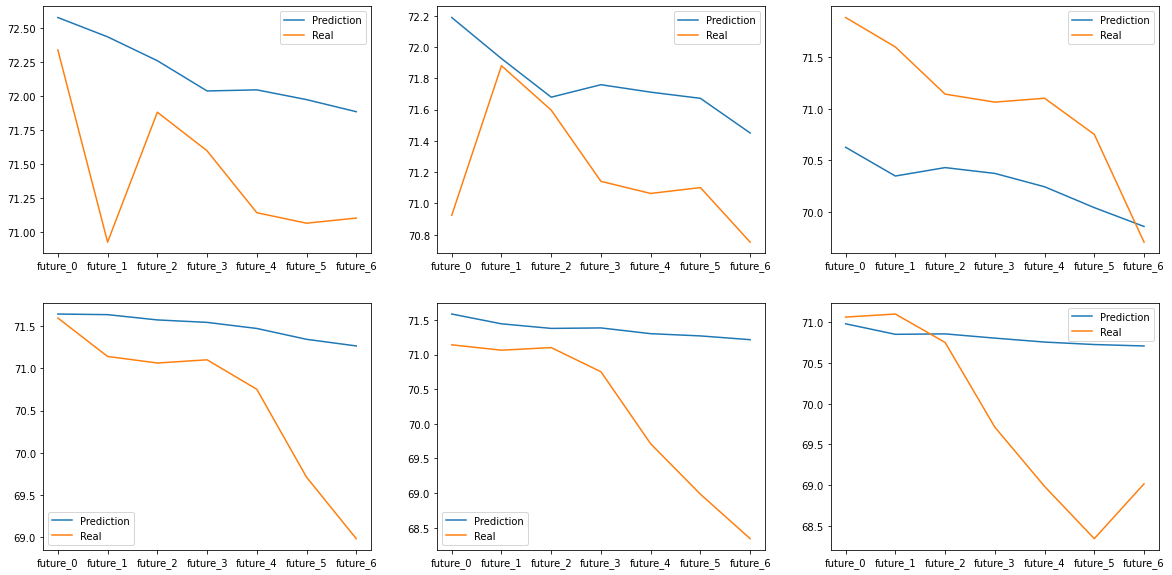

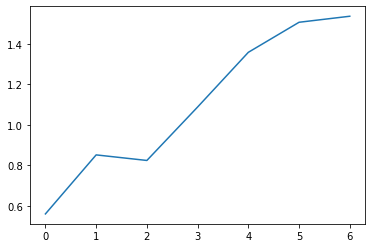

In [15]:
from sklearn.linear_model import Ridge
model = Ridge(random_state=random_state)
try_model(model, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

# Выводы

Из всех моделей визуально лучше всего ведет себя knn c числом соседей 2-3. Это можно __постараться__ объяснить тем, что таки есть некоторая зависимость курса слудующего дня от курса одного-двух дней до него (а-ля цепь Маркова порядка 2). Однако случайность все равно преобладает над зависимостью. Еще видно, что предсказания knn очень завышены, он совершенно не верит в российскую валюту.

Хорошее поведение по метрике MAE остальных моделей выглядит таковым из-за угадывания одного-двух дней достаточно точно (сломанные часы тоже регулярно угадывают правильное время). За счет этого в одной из точек вклад в ошибку получается почти нулевым.

Кажется, что модели лучше всего угадывают первый день и совершенно игнорируют форму графика цен (кроме knn, он хоть старался).

Матан нам намекал, что линейные модели могут неплохо предсказывать поведение нелинейных явлений только на ооочень маленьком расстоянии от референсной точки, еще в учебниках по матану писали, что не стоит пытаться предсказать курс доллара на неделю вперед.